plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #To change the color ordering from BGR to RGB

# Notebook Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import cv2 as cv
import imghdr

C:\Users\sande\AppData\Local\Temp\ipykernel_4220\1505331735.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


#### Limiting gpu usage to prevent OOM errors

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

##### Importing Images

In [4]:
data_dir = 'data'

In [5]:
image_exts = ['jpeg', 'jpg', 'png', 'gif', 'bmp']

##### Removing any dodgy images

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
#             img = cv2.imread(image_path) #checks if the image is valid
            tip = imghdr.what(image_path) #checks if the image has a valid extension
            if tip not in image_exts:
                print("Image not in ext list {}", format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}', format(image_path))
            os.remove(image_path)

#### Load data

In [7]:
data = tf.keras.utils.image_dataset_from_directory('Data')

Found 206 files belonging to 3 classes.


In [8]:
data_iterator = data.as_numpy_iterator()

In [9]:
#Class 1: Dog
#Class 0: Cat

batch = data_iterator.next()

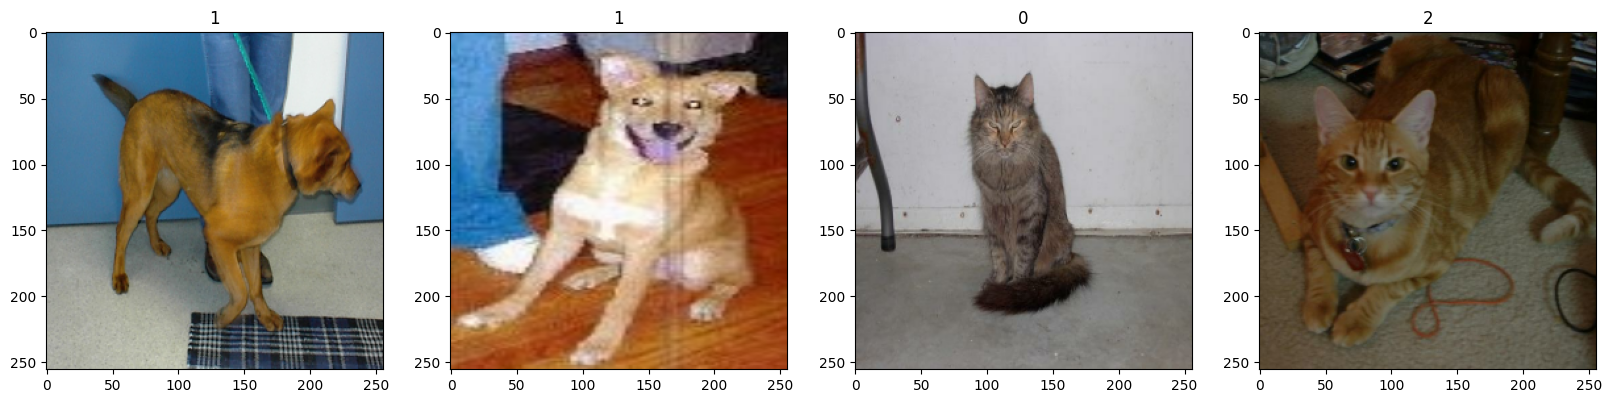

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Preprocess data

##### Scale data

In [11]:
data = data.map(lambda x,y: (x/255, y))

In [12]:
scaled_iterator = data.as_numpy_iterator()

In [13]:
batch = scaled_iterator.next()

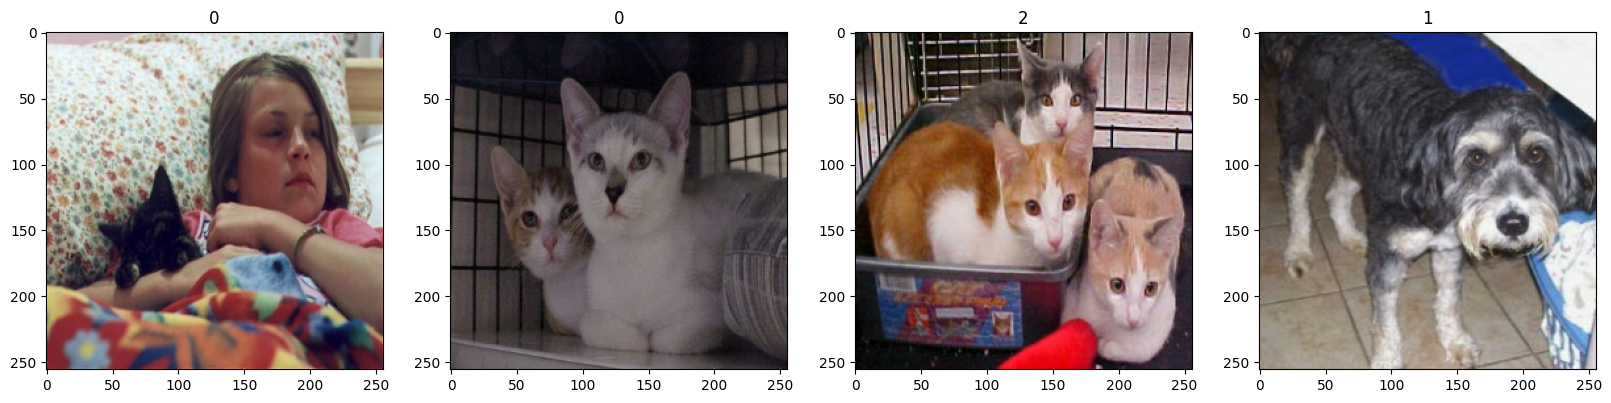

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

##### Split data

In [15]:
train_size = int(len(data)*.33)+1
val_size = int(len(data)*.33)
test_size = int(len(data)*.33)-1

In [16]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### Model

#### Building

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [18]:
model = Sequential()

In [19]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

#### Training

In [22]:
logdir = 'logs'

In [23]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [24]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 5s 1s/step - loss: 1.1320 - accuracy: 0.4896 - val_loss: 0.7980 - val_accuracy: 0.5000
Epoch 2/20
3/3 [==============================] - 3s 1s/step - loss: 0.8268 - accuracy: 0.4688 - val_loss: 0.8419 - val_accuracy: 0.3750
Epoch 3/20
3/3 [==============================] - 3s 1s/step - loss: 0.7567 - accuracy: 0.4479 - val_loss: 0.7018 - val_accuracy: 0.4844
Epoch 4/20
3/3 [==============================] - 3s 852ms/step - loss: 0.6879 - accuracy: 0.5312 - val_loss: 0.6917 - val_accuracy: 0.6562
Epoch 5/20
3/3 [==============================] - 2s 811ms/step - loss: 0.6895 - accuracy: 0.7396 - val_loss: 0.6848 - val_accuracy: 0.8594
Epoch 6/20
3/3 [==============================] - 2s 801ms/step - loss: 0.6822 - accuracy: 0.7812 - val_loss: 0.6754 - val_accuracy: 0.6562
Epoch 7/20
3/3 [==============================] - 2s 833ms/step - loss: 0.6602 - accuracy: 0.6458 - val_loss: 0.6344 - val_accuracy: 0.7344
Epoch 8/20
3/3 [=============

#### Plotting Performance

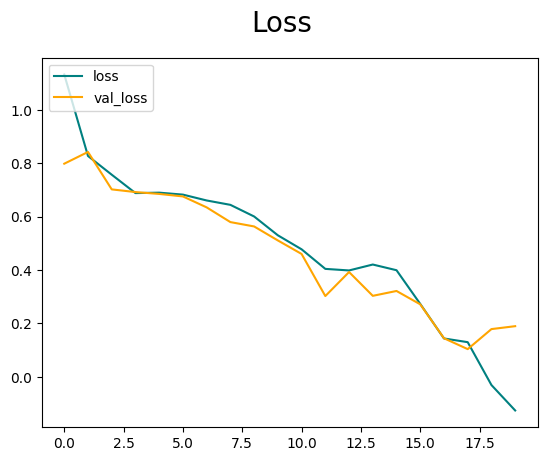

In [25]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

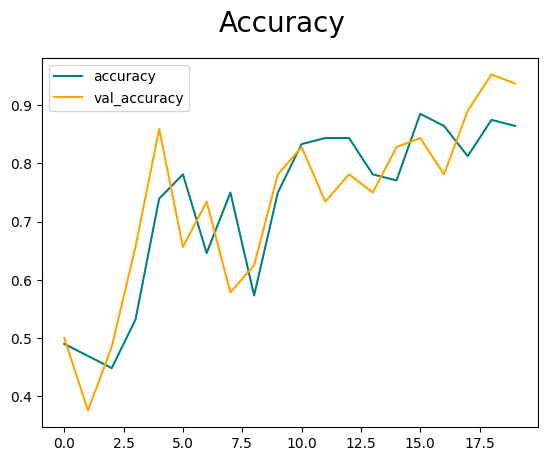

In [26]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Evaluation

#### Evaluate

In [27]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [28]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [29]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 220ms/step


In [30]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:0.8999999761581421, Accuracy:0.875


#### Test

In [31]:
import cv2

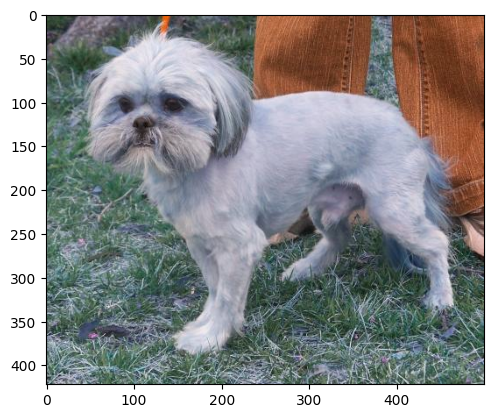

In [82]:
img = cv2.imread("./data/test/dogTest2.jpg")
plt.imshow(img)
plt.show()

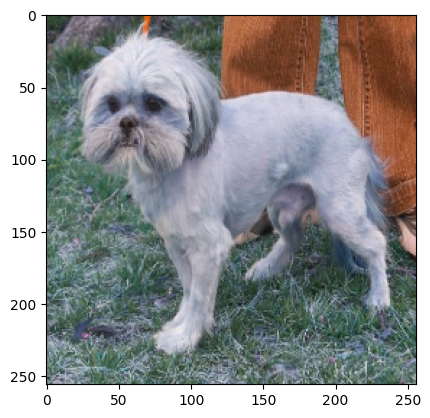

In [83]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [84]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 39ms/step


In [85]:
yhat

array([[0.9991258]], dtype=float32)

In [86]:
if yhat > 0.5:
    print(f'This is a Dog.')
else:
    print(f'This is a Cat.')

This is a Dog.


#### Saving the model

In [37]:
model.save(os.path.join('Models', 'binaryClassification.h5'))